In [1]:
import sys
from pathlib import Path

# Notebook-Ordner → Projektroot (Ordner über "notebooks")
PROJECT_ROOT = Path.cwd().resolve().parents[0]
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Using project root:", PROJECT_ROOT)
print("Added to sys.path:", SRC_DIR)


Using project root: C:\1_Projekte\quantum_cognition
Added to sys.path: C:\1_Projekte\quantum_cognition\src


In [2]:
import re
from pathlib import Path

import pandas as pd

from quantum_cognition.segmentation_keyphrases import KEYPHRASE_SETS

In [ ]:

# =============================================================================
# 1. Pfade & Input
# =============================================================================
PANEL_CSV = Path(r"C:\1_Projekte\quantum_cognition\data\1-3_panel_with_sentiment\transcript_panel_finbert.csv")
OUTPUT_CSV = Path(r"C:\1_Projekte\quantum_cognition\data\1-4_panel_segmented\transcript_panel_segmentation.csv")  # TODO: anpassen

df = pd.read_csv(PANEL_CSV)

# Sicherstellen, dass Text-Spalte existiert und für Suche vorbereitet ist
text_series = df["text"].fillna("")  # keine NaNs
# Hinweis: case=False in str.contains macht weitere Normalisierung unnötig

In [4]:
def normalize_text(s: str) -> str:
    """Normalisiert Text für robuste Phrase-Matches:
    - case-insensitive
    - entfernt Zeichensetzung
    - ersetzt Sonderzeichen durch Leerzeichen
    - reduziert Mehrfach-Leerzeichen
    """
    if not isinstance(s, str):
        return ""

    s = s.lower()

    # Alle Zeichen außer a-z, 0-9, Leerzeichen → durch Leerzeichen ersetzen
    s = re.sub(r"[^a-z0-9]+", " ", s)

    # Mehrfachspaces reduzieren
    s = re.sub(r"\s+", " ", s).strip()

    return s


In [5]:
# =============================================================================
# 2. Funktion: Keyphrase-Flags setzen
# =============================================================================
def add_keyphrase_flags(
    data: pd.DataFrame,
    text_col: str,
    keyphrase_sets: dict[str, list[str]],
) -> pd.DataFrame:
    """Erzeugt 0/1-Flags für Keyphrase-Sets, robust gegen Groß/Kleinschreibung
       und Zeichensetzung.

    Args:
        data: DataFrame mit Textspalte und später Flag-Spalten.
        text_col: Name der Textspalte.
        keyphrase_sets: dict von Spaltennamen → Keyphrase-Liste.

    Returns:
        DataFrame mit 0/1-Spalten pro Keyphrase-Gruppe.
    """

    # -------------------------
    # 1) Text einmal global normalisieren (vektorisiert)
    # -------------------------
    s_norm = (
        data[text_col]
        .fillna("")
        .astype(str)
        .apply(normalize_text)
    )

    for col_name, phrases in keyphrase_sets.items():

        # Initialmaske: alles False
        mask = pd.Series(False, index=data.index)

        # -------------------------
        # 2) Jede Phrase normalisieren
        # -------------------------
        norm_phrases = [normalize_text(p) for p in phrases if p.strip()]

        # -------------------------
        # 3) Vektorisierte Suche (Literal-Suche ohne Regex)
        # -------------------------
        for p_norm in norm_phrases:
            if not p_norm:
                continue
            mask |= s_norm.str.contains(p_norm, regex=False)

        data[col_name] = mask.astype("int8")

    return data


In [6]:
# =============================================================================
# 3. Keyphrases anwenden und nach Bedarf gruppenweise inspizieren
# =============================================================================
df = add_keyphrase_flags(df, text_col="text", keyphrase_sets=KEYPHRASE_SETS)

# Optional: Beispielkontrolle pro folder_relative
# df.groupby("folder_relative")[list(KEYPHRASE_SETS.keys())].sum().head()

In [7]:
# =============================================================================
# Q&A-Dummy aus key_phrase_2 je Earnings Call (file_name)
# =============================================================================
# Annahme: df enthält Spalten "file_name" und "key_phrase_2" (0/1, int)

qa_flag = (
    df.groupby("file_name")["key_phrase_2"]  # gruppiere je Earnings Call
      .cumsum()                              # kumulative Summe innerhalb Calls
      .gt(0)                                 # > 0 => ab erstem Treffer True
      .astype("int8")                        # 0/1 als int8 zur Speicherersparnis
)

df["qa_dummy"] = qa_flag


In [8]:
# =============================================================================
# KONTROLLE: STIMMT DIE SEGMENTIERUNG?
# =============================================================================

In [9]:
# =============================================================================
# KONTROLLROUTINE 1: VISUALISIERUNG
# =============================================================================

In [10]:
from quantum_cognition.segmentation_keyphrases import KEYPHRASE_SETS

keyphrases_qna = KEYPHRASE_SETS["key_phrase_2"]


def detect_first_matching_phrase(text: str, phrases: list[str]) -> str | None:
    """Gibt die erste Key Phrase zurück, die im Text vorkommt (case-insensitive).

    Args:
        text: Eingabetext eines Segments.
        phrases: Liste von Key Phrases aus KEYPHRASE_SETS["key_phrase_2"].

    Returns:
        Die erste passende Phrase oder None, falls keine passt.
    """
    text_l = text.lower()
    for phrase in phrases:
        p = phrase.strip().lower()
        if not p:
            continue
        if p in text_l:
            return phrase
    return None


# Nur für Segmente, bei denen key_phrase_2 == 1 ist, lohnt sich die Suche
mask_hits = df["key_phrase_2"] == 1
df["key_phrase_2_match"] = None  # Default

df.loc[mask_hits, "key_phrase_2_match"] = (
    df.loc[mask_hits, "text"]
      .fillna("")
      .astype(str)
      .apply(detect_first_matching_phrase, phrases=keyphrases_qna)
)


In [11]:
import numpy as np
import pandas as pd


def summarize_call(group: pd.DataFrame) -> pd.Series:
    """Erzeugt Kontrollinformationen für einen Earnings Call (file_name-Gruppe).

    Args:
        group: DataFrame-Gruppe eines Earnings Calls.

    Returns:
        Series mit Kontrollkennzahlen.
    """
    has_qa_transition = int(group["qa_dummy"].max())
    n_segments = len(group)
    n_key2_hits = int(group["key_phrase_2"].sum())

    if has_qa_transition:
        # Position (0-basiert) des ersten qa_dummy == 1 in dieser Gruppe
        pos_arr = np.where(group["qa_dummy"].to_numpy() == 1)[0]
        first_pos = int(pos_arr[0]) if len(pos_arr) > 0 else pd.NA
        # dazugehörige Phrase:
        first_phrase = group["key_phrase_2_match"].iloc[first_pos]
    else:
        first_pos = pd.NA
        first_phrase = pd.NA

    return pd.Series(
        {
            "has_qa_transition": has_qa_transition,
            "n_segments": n_segments,
            "n_key2_hits": n_key2_hits,
            "first_qa_pos": first_pos,
            "first_trigger_phrase": first_phrase,
        }
    )


call_summary = (
    df.groupby("file_name", sort=False)
      .apply(summarize_call)
      .reset_index()
)

call_summary.head()


C:\Users\vsmr25\AppData\Local\Temp\ipykernel_28124\4227490678.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_call)


,file_name,has_qa_transition,n_segments,n_key2_hits,first_qa_pos,first_trigger_phrase
0,earnings_conference_call_ABI.BR_2024_Q3_202410...,1,563,2,149,The floor is now open for questions
1,earnings_conference_call_ABI.BR_2024_Q4_202502...,1,651,3,268,hand it back to the operator for the Q&A
2,earnings_conference_call_ABI.BR_2025_Q1_202505...,1,515,3,103,hand it back to the operator for the Q&A
3,earnings_conference_call_ABI.BR_2025_Q2_202507...,1,555,1,176,The floor is now open for questions
4,earnings_conference_call_AIRP.PA_2024_FullYear...,0,156,0,<NA>,<NA>


In [12]:
import matplotlib.pyplot as plt


def plot_qa_segmentation_for_call(
    data: pd.DataFrame,
    file_name: str,
    max_segments: int | None = None,
) -> None:
    """Visualisiert die Q&A-Segmentierung für einen Earnings Call.

    Args:
        data: Panel-DataFrame mit Spalten:
            - file_name
            - segment_index (oder Int-Index)
            - key_phrase_2
            - qa_dummy
        file_name: Name des Earnings Calls (eindeutig).
        max_segments: Optional, maximale Anzahl Segmente (z.B. für Vorschau).
    """
    call_df = data[data["file_name"] == file_name].copy()

    if call_df.empty:
        print(f"Keine Daten für file_name = {file_name}")
        return

    if max_segments is not None:
        call_df = call_df.head(max_segments)

    if "segment_index" in call_df.columns:
        x = call_df["segment_index"]
        x_label = "Segment index"
    else:
        x = call_df.index
        x_label = "Row index"

    fig, ax = plt.subplots(figsize=(10, 3))

    # qa_dummy als 0/1-Linie
    ax.step(x, call_df["qa_dummy"], where="mid", label="qa_dummy", linewidth=1.5)

    # key_phrase_2-Treffer markieren
    hits = call_df["key_phrase_2"] == 1
    if hits.any():
        ax.scatter(
            x[hits],
            call_df.loc[hits, "qa_dummy"],
            marker="o",
            s=40,
            label="key_phrase_2 hit",
        )

    # Linie beim ersten Übergang
    if call_df["qa_dummy"].max() > 0:
        first_x = x[call_df["qa_dummy"] == 1].iloc[0]
        ax.axvline(
            first_x,
            linestyle="--",
            linewidth=1.2,
            label="First Q&A transition",
            alpha=0.7,
        )

    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_xlabel(x_label)
    ax.set_ylabel("Dummy")
    ax.set_title(f"Q&A-Segmentierung – {file_name}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    fig.tight_layout()
    plt.show()


In [13]:
from IPython.display import display

keyphrases_qna = KEYPHRASE_SETS["key_phrase_2"]

In [14]:
# 1. Zusammenfassungstabelle pro Earnings Call
def qna_phrase_summary_for_call(
    data: pd.DataFrame,
    file_name: str,
    phrases: list[str],
) -> pd.DataFrame:
    """Erzeugt eine Kontrolltabelle für Q&A-Key Phrases in einem Earnings Call.

    Args:
        data: Panel-DataFrame.
        file_name: Eindeutiger Call-Identifikator (Spalte 'file_name').
        phrases: Liste der Key Phrases aus KEYPHRASE_SETS["key_phrase_2"].

    Returns:
        DataFrame mit Spalten:
            - phrase
            - n_hits
            - segment_indices (Liste)
            - start_times (Liste)
    """
    call_df = data[data["file_name"] == file_name]

    rows: list[dict] = []
    for phrase in phrases:
        phrase_stripped = phrase.strip()
        if not phrase_stripped:
            continue

        mask = call_df["key_phrase_2_match"] == phrase_stripped

        indices = call_df.loc[mask, "segment_index"].tolist() if "segment_index" in call_df.columns else call_df.index[mask].tolist()
        times = call_df.loc[mask, "start_time"].tolist() if "start_time" in call_df.columns else []

        rows.append(
            {
                "phrase": phrase_stripped,
                "n_hits": len(indices),
                "segment_indices": indices,
                "start_times": times,
            }
        )

    return pd.DataFrame(rows)


In [15]:
# 2. Def Funktion: Plot + Tabelle für einen bestimmten Earngins Call
def plot_qa_and_show_summary_for_call(
    data: pd.DataFrame,
    file_name: str,
    phrases: list[str],
    max_segments: int | None = None,
) -> None:
    """Erstellt Plot und Kontrolltabelle für einen Earnings Call.

    Args:
        data: Panel-DataFrame.
        file_name: Eindeutiger Name des Earnings Calls.
        phrases: Liste der Q&A-Key Phrases.
        max_segments: Optional Begrenzung der Segmente im Plot.
    """
    call_df = data[data["file_name"] == file_name].copy()
    if call_df.empty:
        print(f"Keine Daten für file_name = {file_name}")
        return

    if max_segments is not None:
        call_df = call_df.head(max_segments)

    # X-Achse bestimmen
    if "segment_index" in call_df.columns:
        x = call_df["segment_index"]
        x_label = "Segment index"
    else:
        x = call_df.index
        x_label = "Row index"

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 3))

    ax.step(x, call_df["qa_dummy"], where="mid", label="qa_dummy", linewidth=1.5)

    hits = call_df["key_phrase_2"] == 1
    if hits.any():
        ax.scatter(
            x[hits],
            call_df.loc[hits, "qa_dummy"],
            marker="o",
            s=40,
            label="key_phrase_2 hit",
        )

    if call_df["qa_dummy"].max() > 0:
        first_x = x[call_df["qa_dummy"] == 1].iloc[0]
        ax.axvline(
            first_x,
            linestyle="--",
            linewidth=1.2,
            label="First Q&A transition",
            alpha=0.7,
        )

    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_xlabel(x_label)
    ax.set_ylabel("Dummy")
    ax.set_title(f"Q&A-Segmentierung – {file_name}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    fig.tight_layout()
    plt.show()

    # --- Tabelle ---
    summary_df = qna_phrase_summary_for_call(
        data=data,
        file_name=file_name,
        phrases=phrases,
    )
    display(summary_df)


In [17]:
# # Aufrug für einen konkreten Call:
# example_file = df["file_name"].iloc[0]
# plot_qa_and_show_summary_for_call(df, example_file, keyphrases_qna)


=== earnings_conference_call_ABI.BR_2024_Q3_20241031_14.00.vtt ===


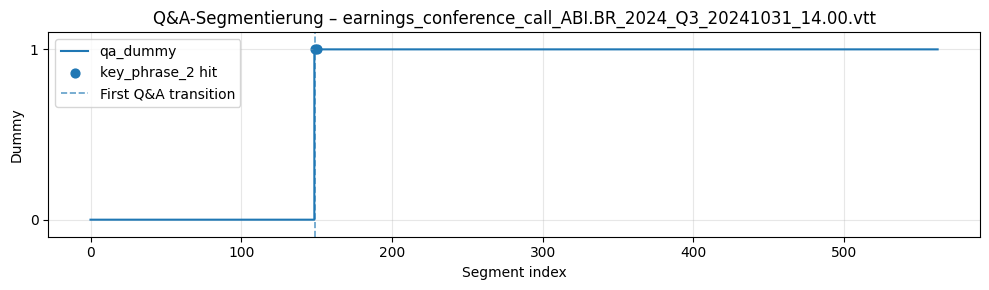

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,1,[149],[17:36.360]
2,we will limit participants to one question,1,[150],[17:45.080]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ABI.BR_2024_Q4_20250226_13.00.vtt ===


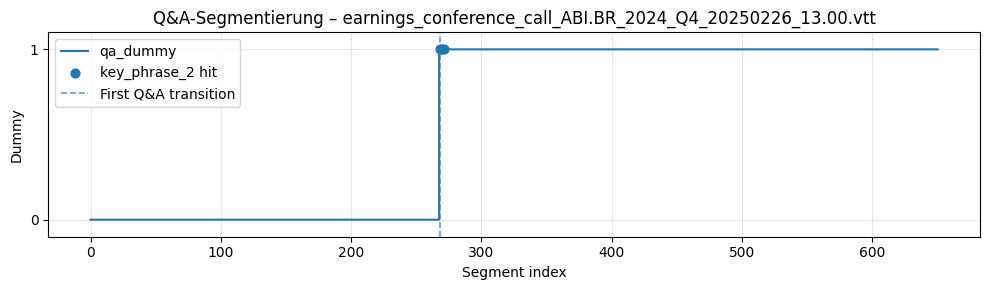

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,1,[270],[26:57.240]
2,we will limit participants to one question,1,[271],[26:59.440]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ABI.BR_2025_Q1_20250508_15.00.vtt ===


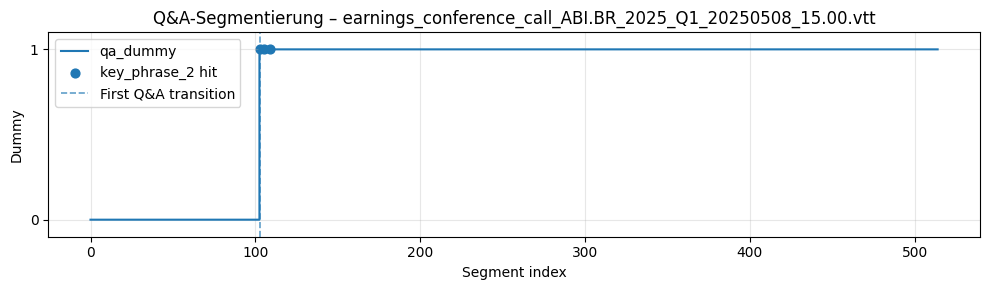

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ABI.BR_2025_Q2_20250731_15.00.vtt ===


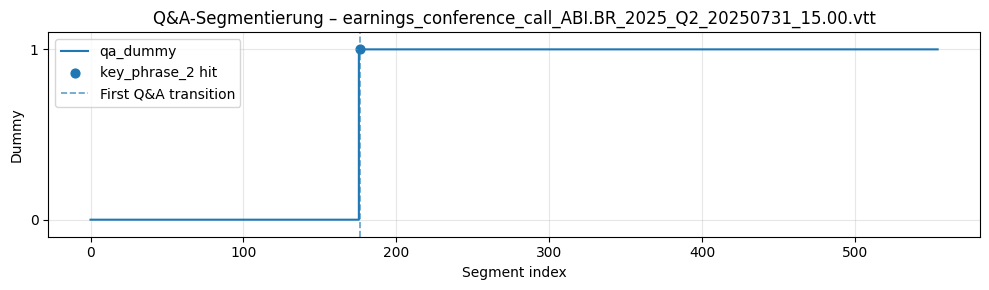

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,1,[176],[22:07.960]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_AIRP.PA_2024_FullYear_20250221_11.00.vtt ===


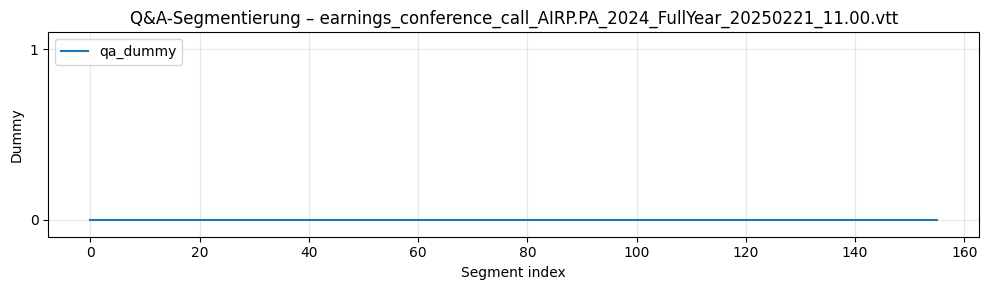

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_AIRP.PA_2025_HalfYear_20250729_10.30.vtt ===


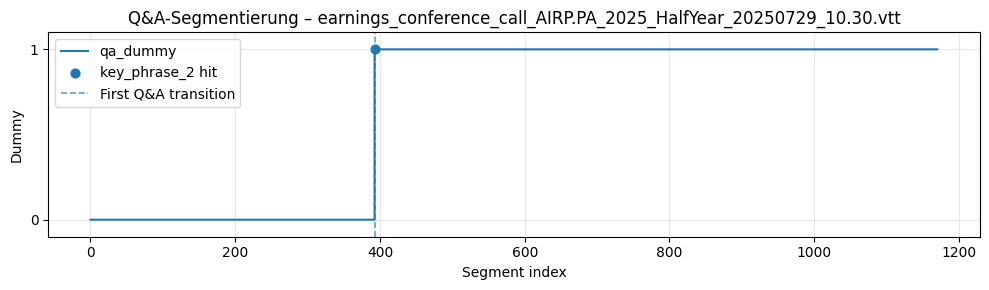

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,1,[393],[29:28.360]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ALVG.DE_2024_Q3_20241113_14.30.vtt ===


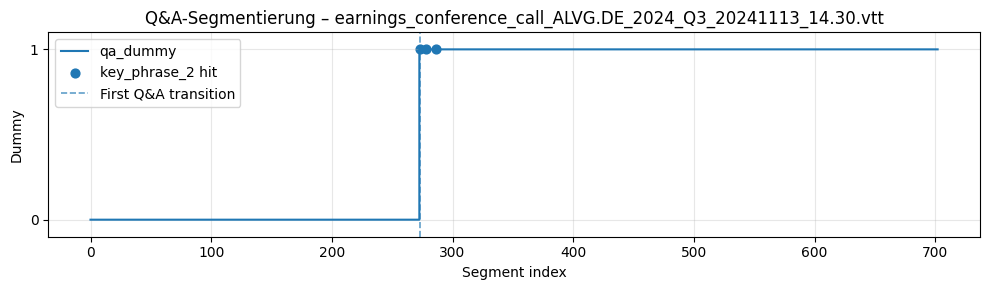

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ALVG.DE_2024_Q4_20250228_14.00.vtt ===


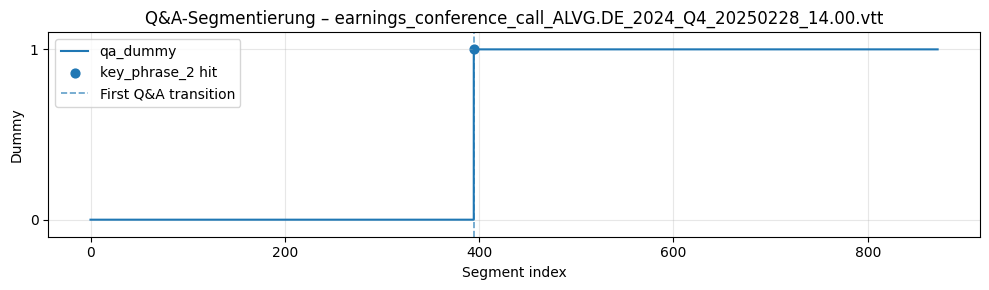

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ALVG.DE_2025_Q1_20250515_14.00.vtt ===


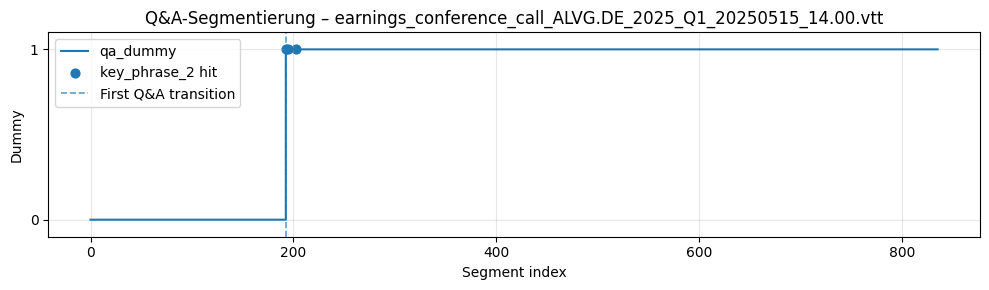

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ALVG.DE_2025_Q2_20250807_14.30.vtt ===


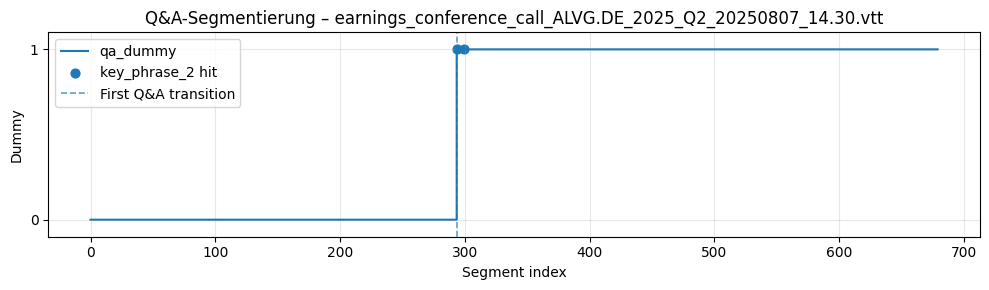

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ASML.AS_2024_Q3_20241016_15.00.vtt ===


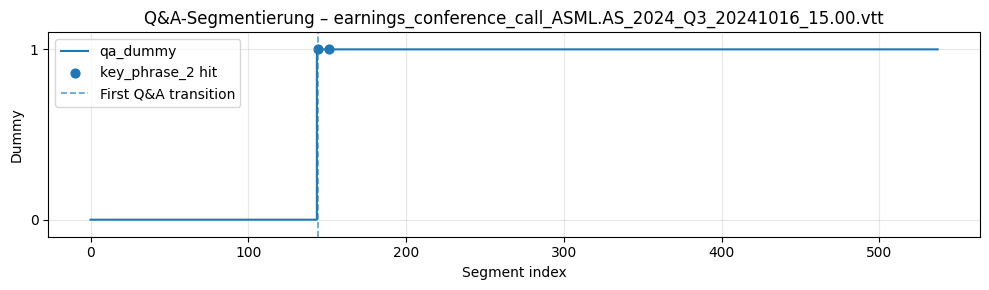

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[151],[15:49.360]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ASML.AS_2024_Q4_20240129_15.00.vtt ===


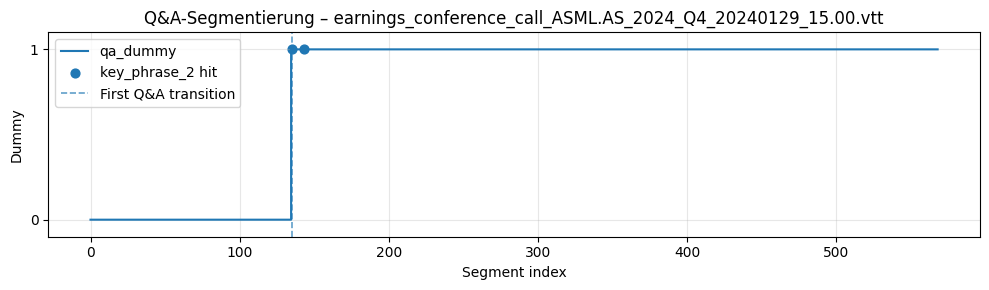

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[143],[17:44.560]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ASML.AS_2025_Q1_20250416_15.00.vtt ===


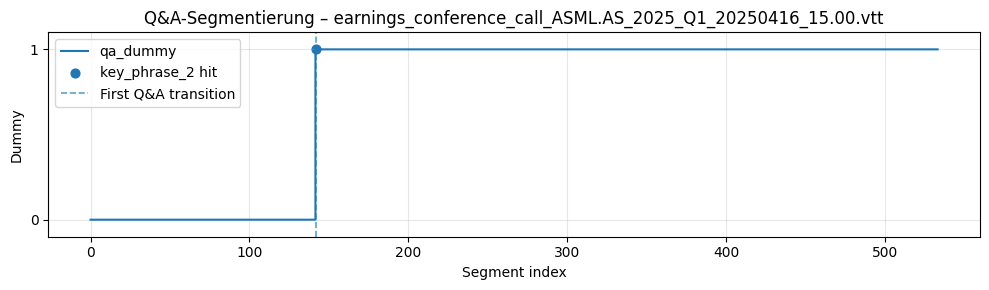

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[142],[15:26.400]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ASML.AS_2025_Q2_20250716_15.00.vtt ===


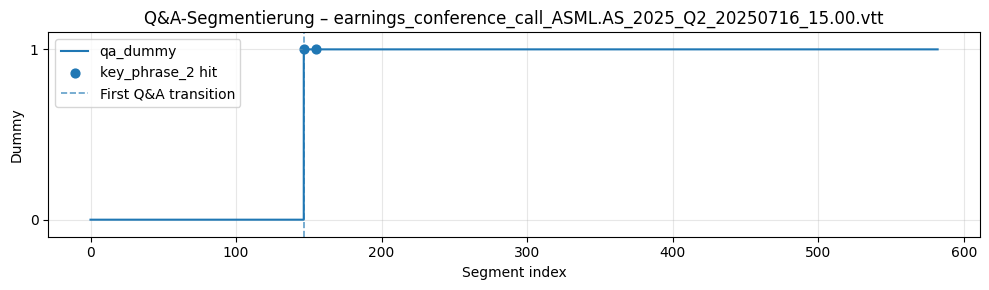

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[155],[15:59.920]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earning_conference_call_DTEGn.DE_2024_Q3_20241114_NTS.vtt ===


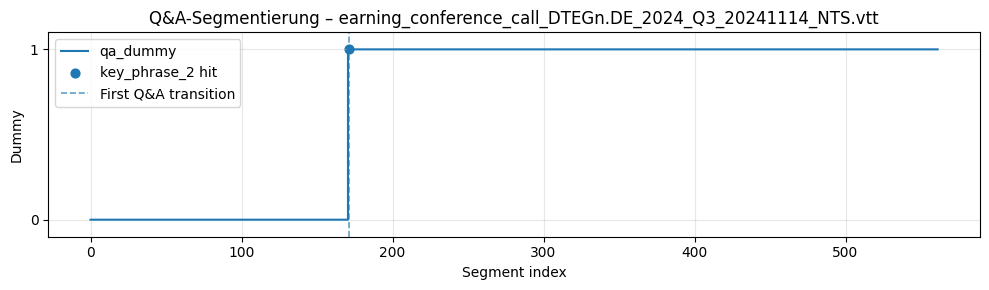

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,1,[171],[14:48.220]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_DTEGn.DE_2024_Q4_20250226_NTS.vtt ===


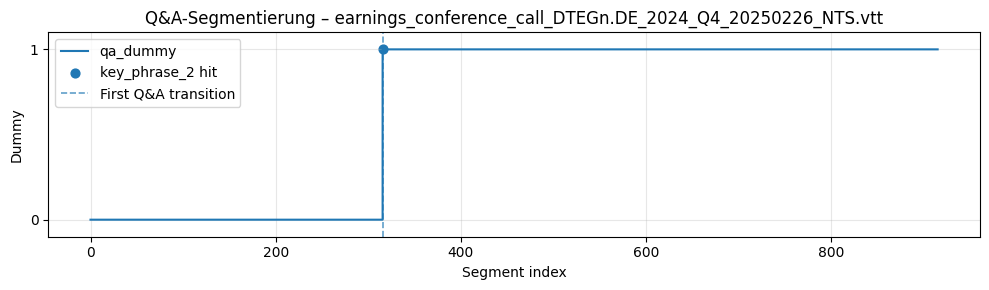

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,1,[316],[37:50.000]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_DTEGn.DE_2025_Q1_20250515_NTS.vtt ===


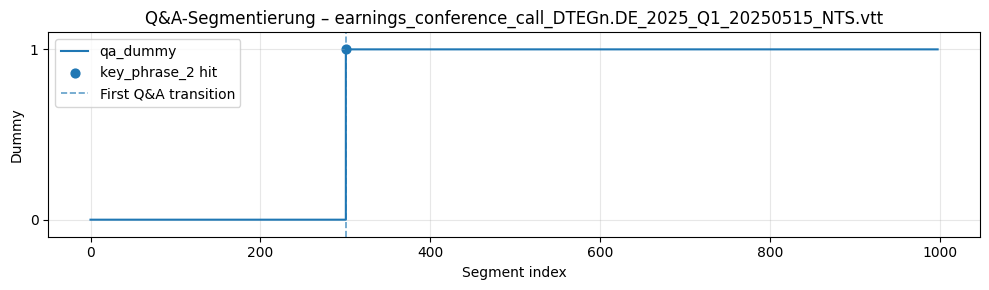

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,1,[301],[24:43.020]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_DTEGn.DE_2025_Q2_20250807_14.00.vtt ===


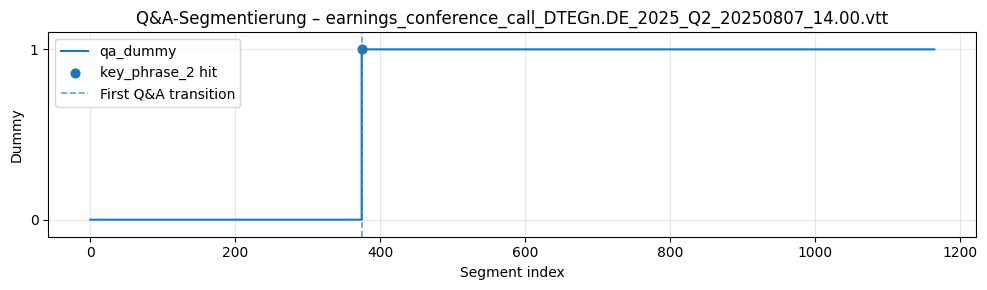

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,1,[375],[23:35.840]


=== earnigns_conference_call_ESLX.PA_2025_HalfYear_20250728_18.30.vtt ===


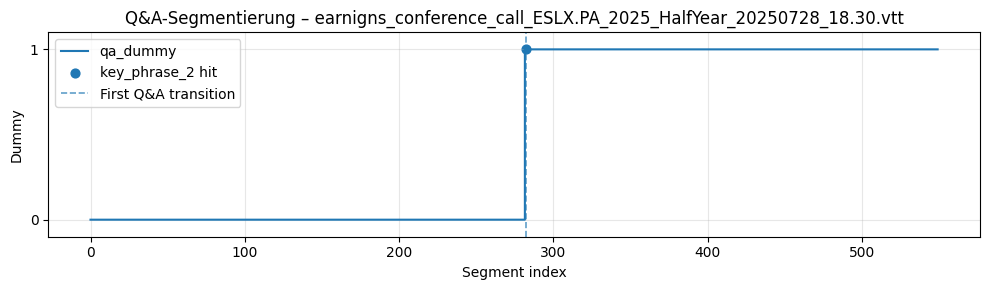

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,1,[282],[30:32.200]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_ESLX.PA_2024_FullYear_20250212_18.30.vtt ===


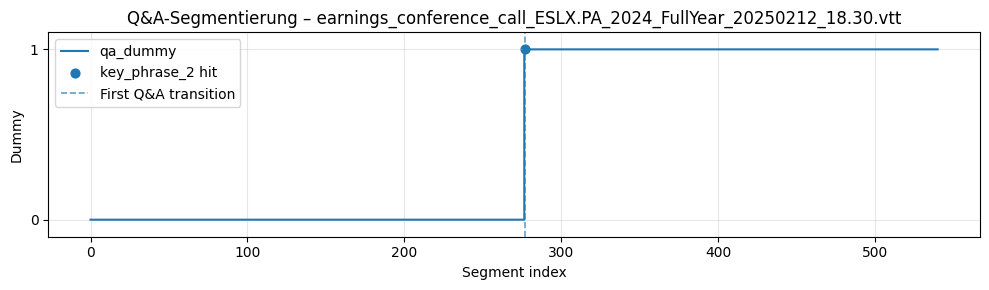

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,1,[277],[31:03.280]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_IBE.MC_2024_FullYear_20250227_09.30.vtt ===


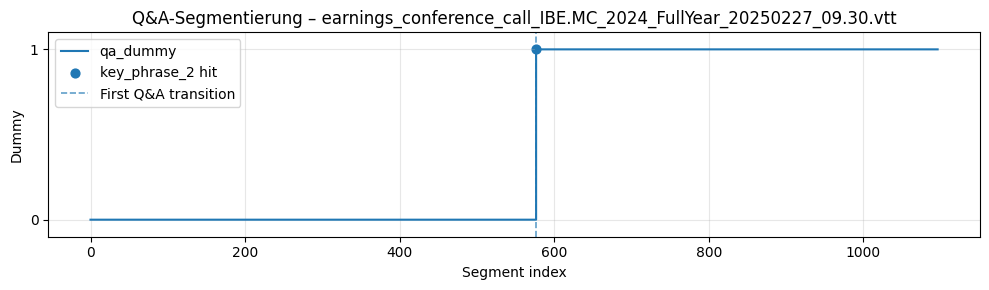

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,1,[577],[37:29.000]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_IBE.MC_2025_HalfYear_20250723_09.00.vtt ===


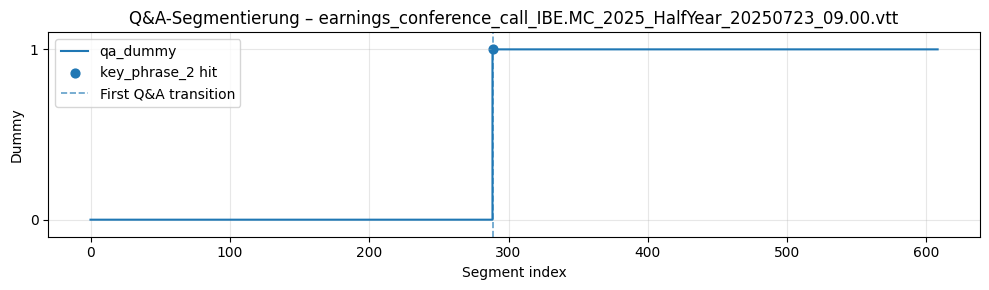

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,1,[289],[31:10.840]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_IBE.MC_2025_Q1_20250430_09.30.vtt ===


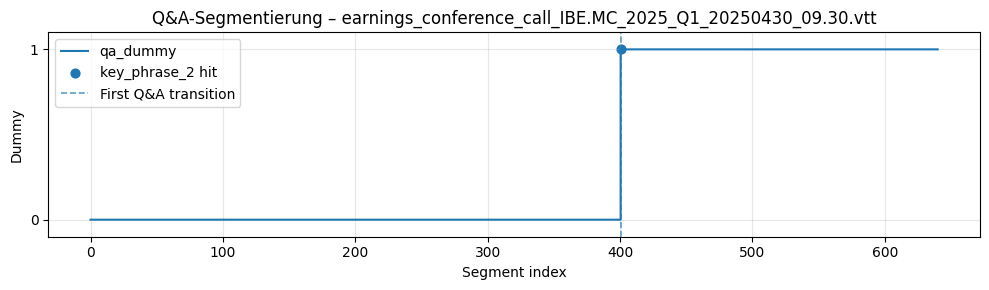

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,1,[401],[26:55.000]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_LVMH.PA_FullYear_2024_20250128_18.00.vtt ===


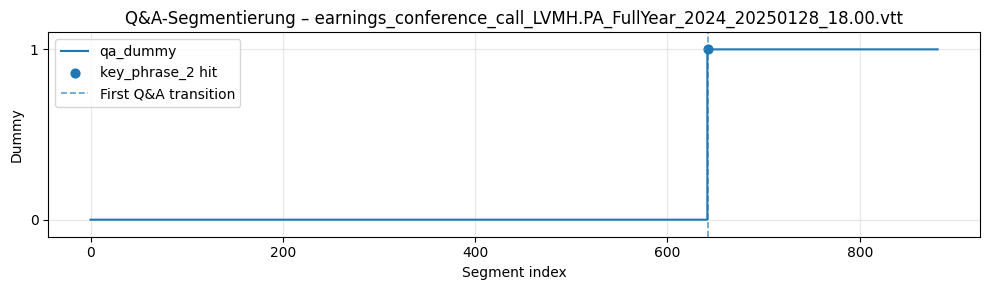

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_LVMH.PA_HalfYear_2025_20250724_18.00.vtt ===


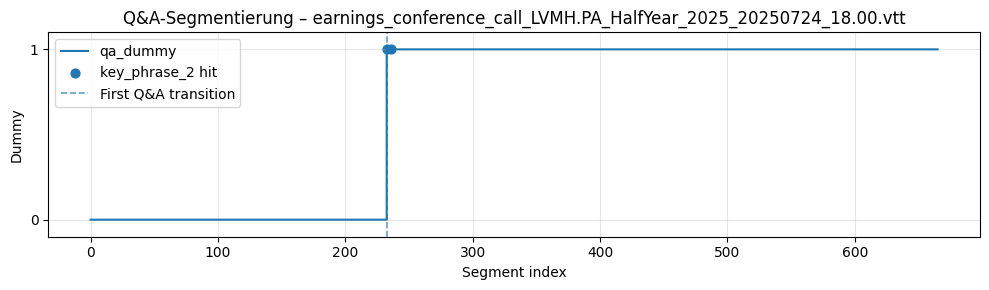

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_OREP.PA_2025_HalfYear_20250730_09.00.vtt ===


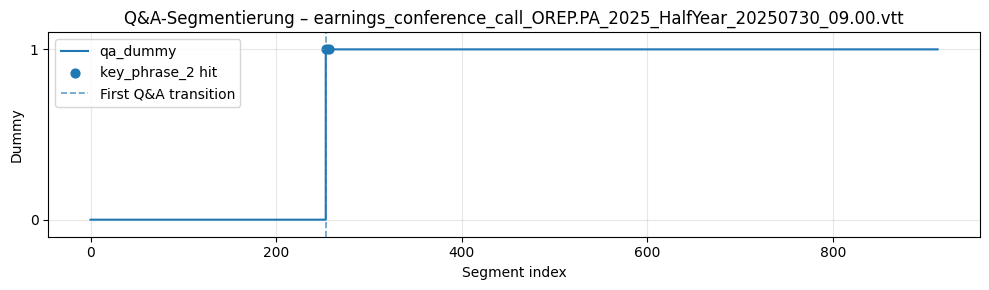

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_SIEGn.DE_2024_Q4_20241114_10.00.vtt ===


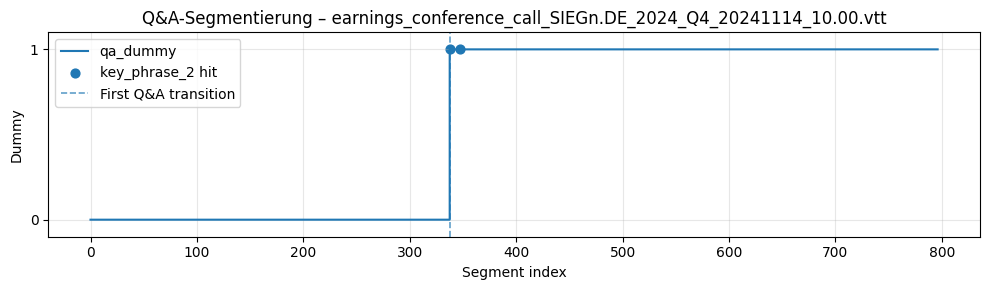

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_SIEGn.DE_2025_Q1_20250213_08.30.vtt ===


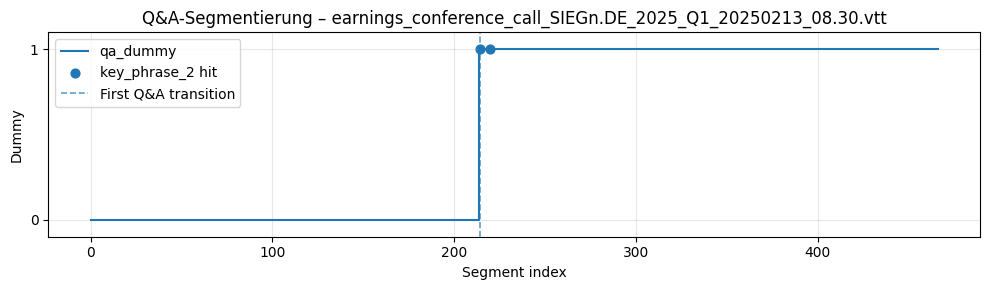

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[220],[23:36.320]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_SIEGn.DE_2025_Q2_20250515_09.30.vtt ===


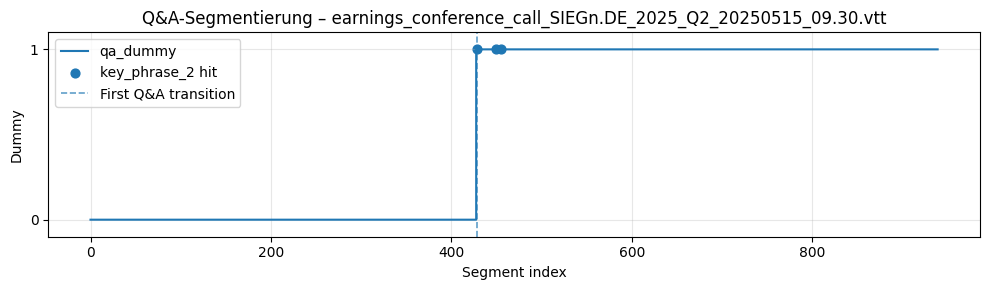

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[455],[35:09.360]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_SIEGn.DE_2025_Q3_20250807_09.30.vtt ===


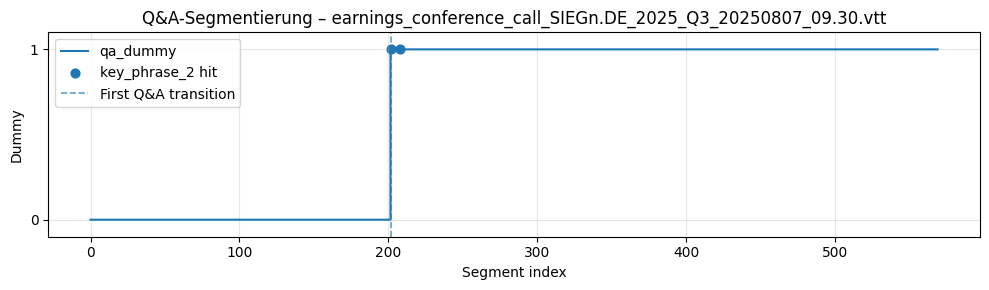

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[208],[22:08.320]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_TTEF.PA_2024_Q3_20241031_12.00.vtt ===


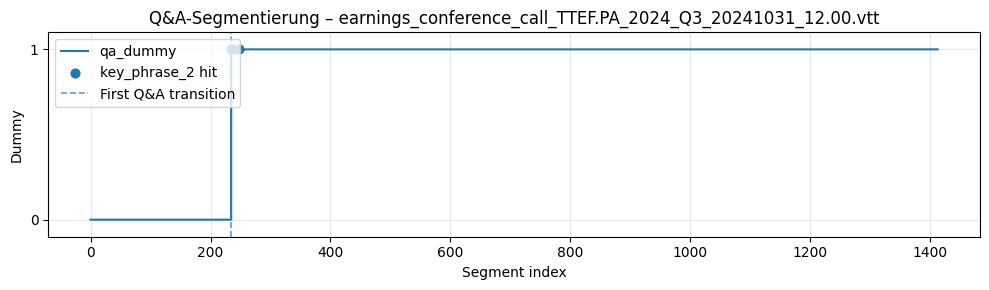

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_TTEF.PA_2025_HalfYear_20250724_13.00.vtt ===


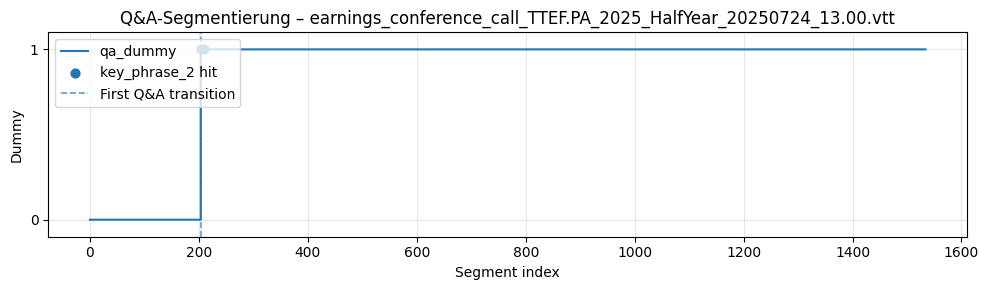

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_TTEF.PA_2025_Q1_20250430_13.00.vtt ===


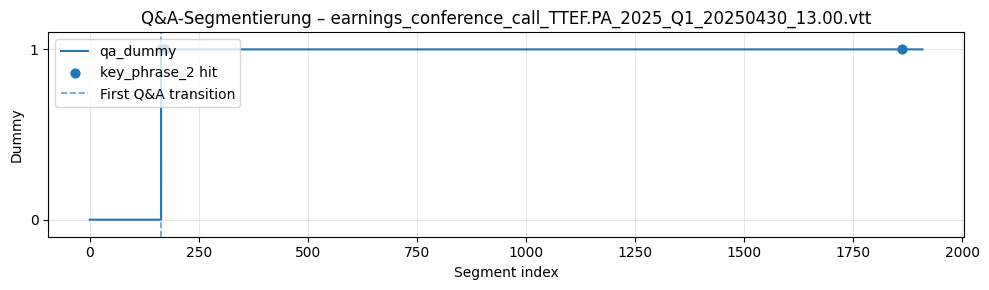

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_VNAn.DE_2024_Q3_20241106_14.00.vtt ===


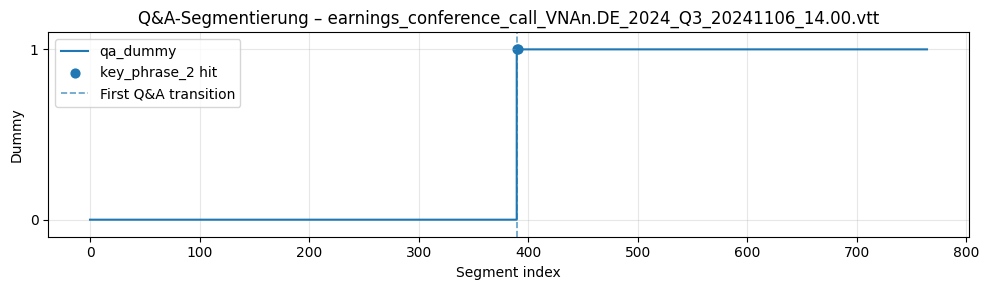

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[391],[44:48.560]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_VNAn.DE_2024_Q4_20250319_14.00.vtt ===


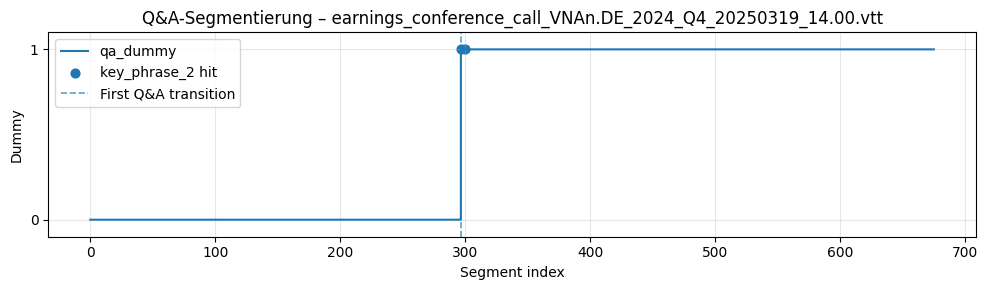

,phrase,n_hits,segment_indices,start_times
0,first question comes from,0,[],[]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


=== earnings_conference_call_VNAn.DE_2025_HalfYear_20250806_14.00.vtt ===


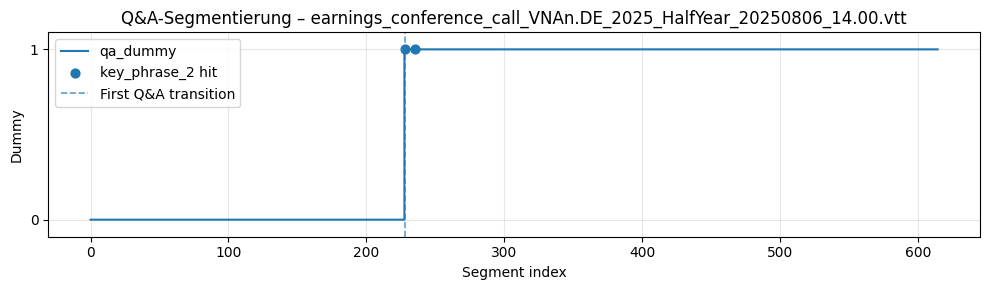

,phrase,n_hits,segment_indices,start_times
0,first question comes from,1,[235],[23:07.680]
1,The floor is now open for questions,0,[],[]
2,we will limit participants to one question,0,[],[]
3,we will now start the Q&A session,0,[],[]
4,we are going to take the Q&A now,0,[],[]
5,ready to answer all your questions,0,[],[]
6,starting with the Q&A,0,[],[]
7,we can start with the Q&A,0,[],[]
8,start with the Q&A,0,[],[]
9,we have the Q&A,0,[],[]


In [18]:
# Ausgabe für alle Calls (Iteration via For-Schleife)
unique_files = df["file_name"].drop_duplicates().tolist()

for fn in unique_files:
    print(f"=== {fn} ===")
    plot_qa_and_show_summary_for_call(df, fn, keyphrases_qna)


In [19]:
def qna_phrase_global_summary(
    data: pd.DataFrame,
    phrases: list[str],
) -> pd.DataFrame:
    """Summary-Statistik für Q&A-Phrasen im gesamten Panel."""

    n_calls_total = data["file_name"].nunique()
    rows = []

    for phrase in phrases:
        p = phrase.strip()
        if not p:
            continue

        mask = data["key_phrase_2_match"] == p

        total_hits = int(mask.sum())
        n_calls_with_phrase = data.loc[mask, "file_name"].nunique()

        coverage = (
            round(n_calls_with_phrase / n_calls_total, 2)
            if n_calls_total > 0 else 0.00
        )

        rows.append(
            {
                "phrase": p,
                "total_hits": total_hits,
                "n_calls_with_phrase": n_calls_with_phrase,
                "coverage_share": coverage,
            }
        )

    return pd.DataFrame(rows)


In [20]:
# Aufruf
keyphrases_qna = KEYPHRASE_SETS["key_phrase_2"]
summary_phrases = qna_phrase_global_summary(df, keyphrases_qna)
summary_phrases


,phrase,total_hits,n_calls_with_phrase,coverage_share
0,first question comes from,9,9,0.25
1,The floor is now open for questions,3,3,0.08
2,we will limit participants to one question,2,2,0.06
3,we will now start the Q&A session,2,2,0.06
4,we are going to take the Q&A now,1,1,0.03
5,ready to answer all your questions,1,1,0.03
6,starting with the Q&A,2,2,0.06
7,we can start with the Q&A,2,2,0.06
8,start with the Q&A,1,1,0.03
9,we have the Q&A,1,1,0.03


In [21]:
n_calls_total = df["file_name"].nunique()
n_calls_total


36

In [22]:
# =============================================================================
# 4. Export (robust: erstellt fehlende Ordner automatisch)
# =============================================================================

# Ordner für Output-Datei anlegen, falls nicht vorhanden
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)

df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

print(
    f"Fertig. {len(df)} Zeilen, neue Spalten: {list(KEYPHRASE_SETS.keys())}\n"
    f"Exportiert nach: {OUTPUT_CSV}"
)


Fertig. 28157 Zeilen, neue Spalten: ['key_phrase_1', 'key_phrase_2']
Exportiert nach: C:\1_Projekte\quantum_cognition\data\1-4_panel_with_sentiment\transcript_panel_segmentation.csv
